In [1]:
# Imports
'''
# ants is not available in this notebook
import ants
import ants.io
import ants.io.save as save
'''
import cftime
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import os
from iris import cube # See https://github.com/SciTools/iris/issues/4683
from iris.util import equalise_attributes
from pathlib import Path

In [2]:
# Constants and parameters
iris.FUTURE.date_microseconds = True

# Defined in the environment
PROJECT = os.environ['PROJECT']
USER = os.environ['USER']

# Defined in site/nci-gadi/variables.cylc
ANCIL_TARGET_PATH = f'/g/data/{PROJECT}/{USER}/CMIP7/esm16_ancil'
CMIP7_SOURCE_DATA_DIRNAME = '/g/data/qv56/replicas/input4MIPs/CMIP7/CMIP'
ESM15_INPUTS_PATH = '/g/data/vk83/configurations/inputs/access-esm1p5'

# Defined in rose-suite.conf
CMIP7_NITROGEN_VERSION = 'FZJ-CMIP-nitrogen-1-2'
CMIP7_NITROGEN_VDATE = 'v20251025'
CMIP7_PI_NITROGEN_DATE_RANGE = '185001-185012'
ESM_GRID_DIRNAME = 'global.N96'
ESM_PI_NITROGEN_SAVE_FILENAME = 'Ndep_1850_cmip7.anc'
ESM15_GRID_VERSION = '2020.05.19'

# Defined in CMIP7/esm1p6/atmosphere/cmip7_ancil_constants.py
UM_VERSION = '7.3'

# Defined in CMIP7/esm1p6/atmosphere/cmip7_ancil_common.py
INTERPOLATION_SCHEME = iris.analysis.AreaWeighted(mdtol=0.5)

# To be defined in CMIP7/esm1p6/atmosphere/nitrogen/cmip7_nitrogen.py
NITROGEN_SPECIES = ('drynhx', 'drynoy', 'wetnhx', 'wetnoy')
NITROGEN_STASH_ITEM = 447 # m01s00i447 is NITROGEN DEPOSITION (kgN/m2/s)

In [3]:
# Defined in CMIP7/esm1p6/atmosphere/cmip7_ancil_common.py

In [4]:
def esm_grid_mask_filepath():
    return (
        Path(ESM15_INPUTS_PATH)
        / "modern"
        / "share"
        / "atmosphere"
        / "grids"
        / ESM_GRID_DIRNAME
        / ESM15_GRID_VERSION
        / "qrparm.mask"
    )

In [5]:
def esm_grid_mask_cube():
    cube = iris.load_cube(esm_grid_mask_filepath())
    cube.coord("latitude").guess_bounds()
    cube.coord("longitude").guess_bounds()
    return cube

In [6]:
def set_gregorian(var):
    # Change the calendar to Gregorian for the model
    time = var.coord("time")
    origin = time.units.origin

In [7]:
def fix_coords(cube):
    esm_grid_mask = esm_grid_mask_cube()
    cube.coord("latitude").coord_system = esm_grid_mask.coord(
        "latitude"
    ).coord_system
    cube.coord("longitude").coord_system = esm_grid_mask.coord(
        "longitude"
    ).coord_system

In [8]:
def save_ancil(cubes, save_dirpath, save_filename):
    """
    Handle both a list and a single cube
    """
    if not isinstance(cubes, list):
        cubes = [cubes]
    """
    Set correct cube grid and time attributes
    Single year creates file with correct time_type=2
    """
    for cube in cubes:
        cube.attributes["grid_staggering"] = 3  # New dynamics
        cube.attributes["time_type"] = 1  # Gregorian
        set_gregorian(cube)
    """
    ANTS doesn't set the calendar header for monthly fields
    See fileformats/ancil/time_headers.py
    UM vn7.3 doesn't handle the missing value, so set the value with mule
    Mule doesn't work in place on a file, so inital save to a temporary
    ANTS creates files with the model_version header set to the ants version.
    UM vn7.3 interprets 201 as an old unsupported dump format.
    Need to reset to 703.
    """
    ants.__version__ = UM_VERSION
    with tempfile.TemporaryDirectory() as temp_dirname:
        save_temp_pathname = fsdecode(Path(temp_dirname) / save_filename)
        save.ancil(cubes, save_temp_pathname)
        sm = mule.STASHmaster.from_version(UM_VERSION)
        ff = mule.AncilFile.from_file(save_temp_pathname, stashmaster=sm)
        ff.fixed_length_header.calendar = 1
        # Ensure that the directory exists.
        save_dirpath.mkdir(mode=0o755, parents=True, exist_ok=True)
        save_file_pathname = fsdecode(save_dirpath / save_filename)
        ff.to_file(save_file_pathname)

In [9]:
# To be defined in CMIP7/esm1p6/atmosphere/nitrogen/cmip7_nitrogen.py

In [10]:
def cmip7_nitrogen_dirpath(period, species):
    return (
        Path(CMIP7_SOURCE_DATA_DIRNAME)
        / "FZJ"
        / CMIP7_NITROGEN_VERSION
        / "atmos"
        / period
        / species
        / "gn"
        / CMIP7_NITROGEN_VDATE
    )

In [11]:
# To be defined in CMIP7/esm1p6/atmosphere/nitrogen/cmip7_PI_nitrogen_generate.py

In [12]:
def cmip7_pi_nitrogen_filepath(species, date_range):
    dirpath = cmip7_nitrogen_dirpath("monC", species)
    filename = (
        f"{species}_input4MIPs_surfaceFluxes_CMIP_"
        f"{CMIP7_NITROGEN_VERSION}_gn_"
        f"{date_range}-clim.nc"
    )
    return dirpath / filename

In [13]:
def load_cmip7_pi_nitrogen_species(species, date_range):
    species_filepath = cmip7_pi_nitrogen_filepath(species, date_range)
    cube = iris.load_cube(species_filepath)
    return cube

In [14]:
def load_cmip7_pi_nitrogen():
    # Load all of the PI nitrogen datasets into a CubeList
    nitrogen_cubes = iris.cube.CubeList()
    for species in NITROGEN_SPECIES:
        species_cube = load_cmip7_pi_nitrogen_species(species, CMIP7_PI_NITROGEN_DATE_RANGE)
        nitrogen_cubes.append(species_cube)
    # Remove all attributes that differ between cubes
    equalise_attributes(nitrogen_cubes)
    # Add the cubes together
    cube_tot = nitrogen_cubes[0].copy()
    for cube_nbr in range(1,4):
        iris.analysis.maths.add(cube_tot, nitrogen_cubes[cube_nbr], in_place=True)
    return cube_tot

In [15]:
def regrid_cmip7_pi_nitrogen(cube):
    # Make the coordinates comaptible with the ESM1.5 grid mask
    fix_coords(cube)
    # Regrid using the ESM1.5 grid mask
    esm_cube = cube_tot.regrid(esm_grid_mask_cube(), INTERPOLATION_SCHEME)
    esm_cube.data = esm_cube.data.filled(0.0)
    return esm_cube

In [16]:
def save_cmip7_pi_nitrogen(cube):
    # Add STASH metadata
    cube.attributes["STASH"] = iris.fileformats.pp.STASH(
        model=1, section=0, item=NITROGEN_STASH_ITEM
    )
    # Do not call save_ancil because ants is not available in this notebook
    # save_ancil(cube, ANCIL_TARGET_PATH, ESM_PI_NITROGEN_SAVE_FILENAME)

In [17]:
# "__main__"
# The main function would also use argparse, but it is not used here
# because all arguments are defined as constants instead.

cube_tot = load_cmip7_pi_nitrogen()

esm_cube = regrid_cmip7_pi_nitrogen(cube_tot)

save_cmip7_pi_nitrogen(esm_cube)


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


In [18]:
# Extra function for plotting

In [19]:
def plot_cmip7_pi_nitrogen(cube):
    for month_m1 in range(12):
        month = month_m1 + 1
        beg_date = cftime.DatetimeNoLeap(1850, month, 1)
        if month == 12:
            end_date = cftime.DatetimeNoLeap(1851, 1, 1)
        else:
            end_date = cftime.DatetimeNoLeap(1850, month+1, 1)
        month_constraint = iris.Constraint(time=lambda cell: beg_date <= cell.point < end_date)
        month_cube = cube.extract(month_constraint)

        print(f"Month == {month}")
        # Add a filled contour, and put the result in a variable called contour.
        contour = qplt.contourf(month_cube)

        # Add coastlines to the map created by contour.
        plt.gca().coastlines()
    
        # Add contour labels based on the contour we have just created.
        plt.clabel(contour, inline=False)

        plt.show()

Month == 1


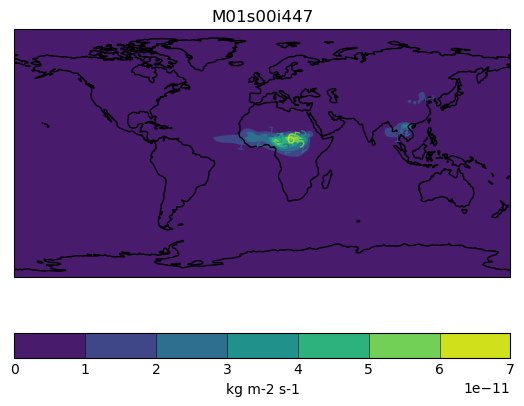

Month == 2


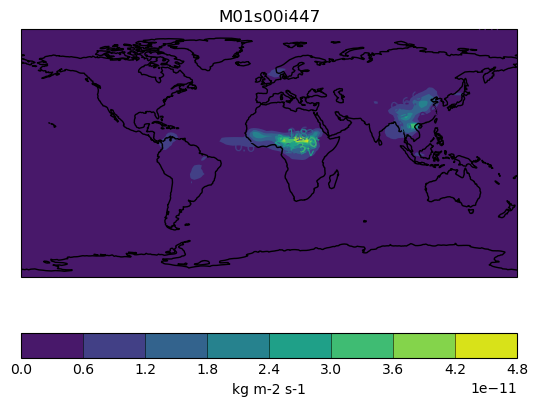

Month == 3


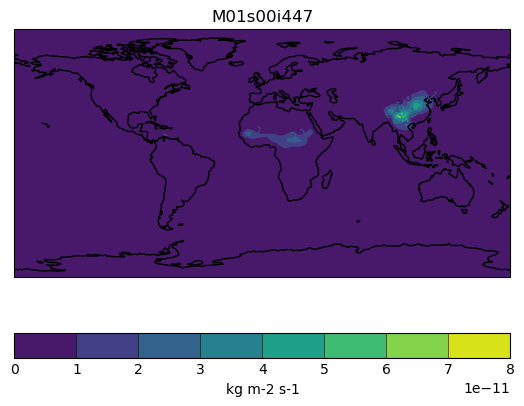

Month == 4


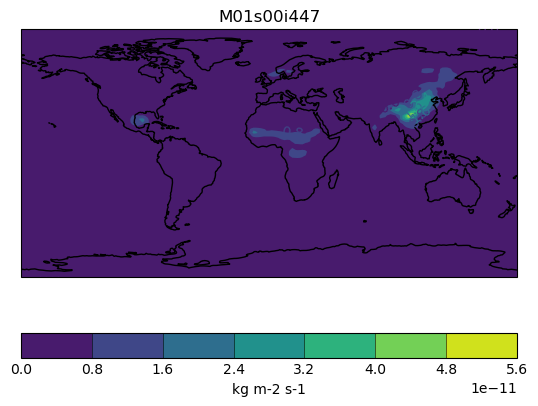

Month == 5


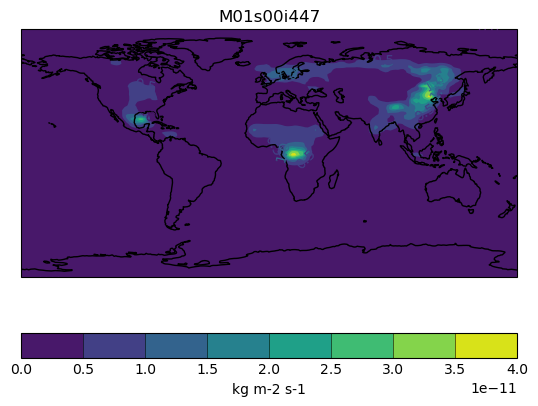

Month == 6


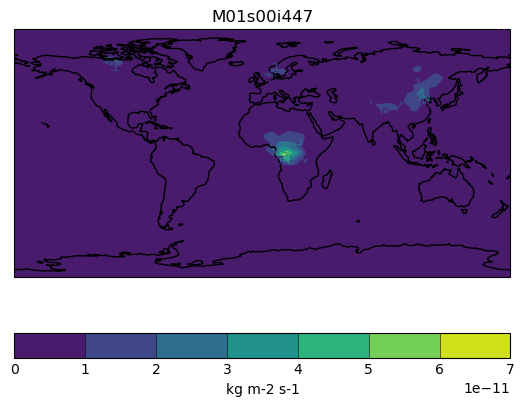

Month == 7


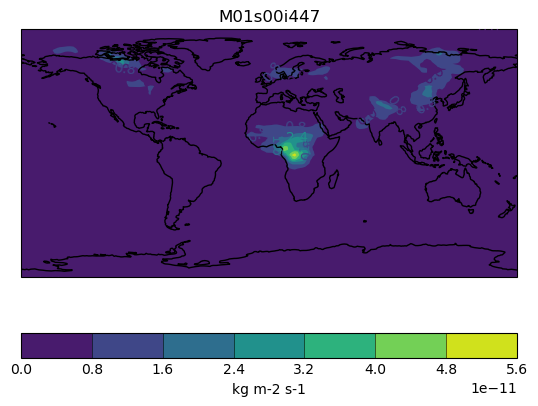

Month == 8


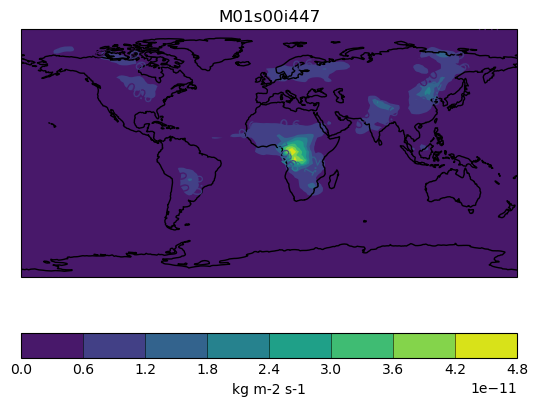

Month == 9


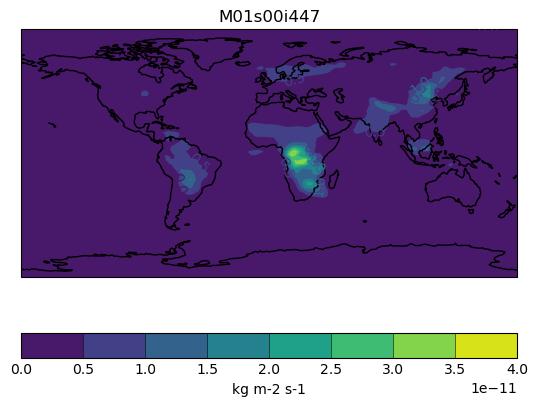

Month == 10


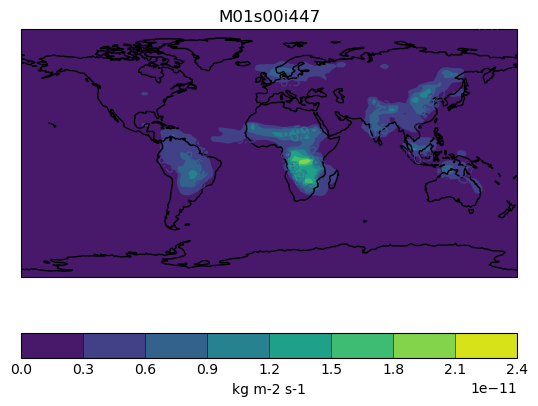

Month == 11


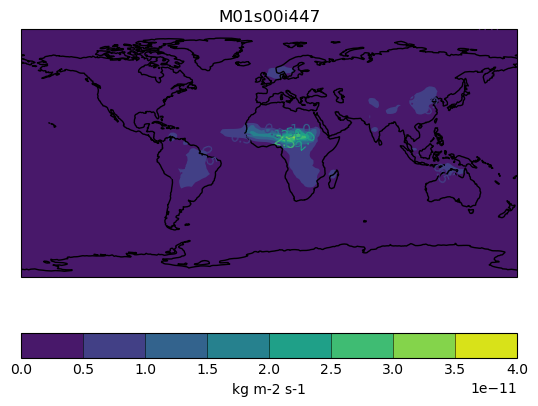

Month == 12


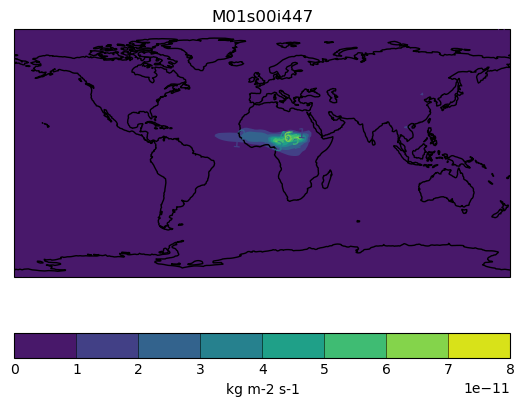

In [20]:
plot_cmip7_pi_nitrogen(esm_cube)